In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
# X_train.reshape(-1,9).shape

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

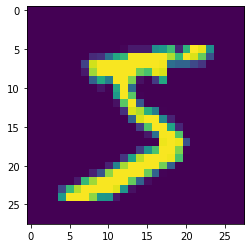

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [10]:
# X_train[0, :, :]
# X_train[0, :, :].reshape([28 * 28])
# ВЫТЯНЕМ ВСЕ КАРТИНКИ В РЯД

In [11]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [12]:
X_train.shape, X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [13]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [14]:
# ВИДИТ ЛИ ТОРЧ ВИДЕОКАРТУ
torch.cuda.is_available()

True

In [15]:
# ЗАНЯТА ЛИ ВИДЕОКАРТА ВЫЧИСЛЕНИЯМИ
!nvidia-smi

Fri Nov 18 20:18:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# ПЕРЕЛОДИТЬ ВЫЧИСЛЕНИЯ НА ВИДЕОКАРТУ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device) # относледовали от торч.нн.модуль
# list(mnist_net.parameters())

In [17]:
device

device(type='cuda', index=0)

In [18]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [19]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9100)
tensor(0.9138)
tensor(0.9198)
tensor(0.9239)
tensor(0.9256)
tensor(0.9230)
tensor(0.9239)
tensor(0.9343)
tensor(0.9364)
tensor(0.9311)


In [20]:
# loss(test_preds, y_test)

In [21]:
# accuracy.detach().help

In [22]:
# test_accuracy_history

[tensor(0.9100),
 tensor(0.9138),
 tensor(0.9198),
 tensor(0.9239),
 tensor(0.9256),
 tensor(0.9230),
 tensor(0.9239),
 tensor(0.9343),
 tensor(0.9364),
 tensor(0.9311)]

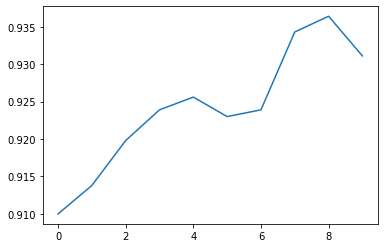

In [23]:
plt.plot(test_accuracy_history)

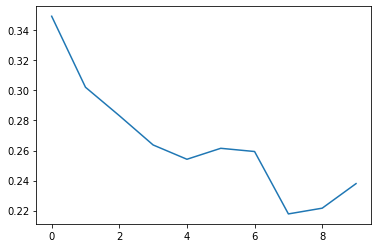

In [26]:
test_loss_history = [test_loss_history[i].data for i in range(len(test_loss_history))]
# test_loss_history
plt.plot(test_loss_history)

Запустите код из видео на GPU. В последнем шаге мы рисовали график accuracy и loss на валидации. А что с ними происходит на train'е?

-----------------------------------------------

* Постройте на одном графике loss для train и validation.
* Правда ли, что loss на train и validation падает одинаково быстро и выходит на одинаковое значение, или же у нас есть переобучение?
* Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
* Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?
* Замедляет ли torch.backends.cudnn.deterministic = True обучение на практике? Если да, то насколько?
* Попробуйте разные методы градиентного спуска, которые были в лекции.  Как выбор градиентного спуска влияет на accuracy? Для уверенности лучше проводить один эксперимент 3-5 раз на разных random seed: так вы поймете, действительно ли сказывается влияние метода или дело в случайности.


Напишите результаты своих исследований в комментариях.

In [29]:
X_test.shape

torch.Size([10000, 784])

In [30]:
X_train.shape

torch.Size([60000, 784])

In [59]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

batch_size = 100

index_check = np.random.permutation(len(X_train))[:len(X_test)]
X_train_check = X_train[index_check].to(device)
y_train_check = y_train[index_check].to(device)
train_accuracy_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
test_accuracy_history = []
test_loss_history = []
# val_accuracy_history = []
# val_loss_history = []

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_preds = mnist_net.forward(X_train_check)
    train_loss_history.append(loss(train_preds, y_train_check).cpu())

    accuracy = (train_preds.argmax(dim=1) == y_train_check).float().mean().cpu()
    train_accuracy_history.append(accuracy)

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
    test_accuracy_history.append(accuracy)

    # print(accuracy)

KeyboardInterrupt: ignored

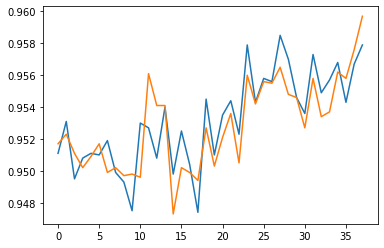

In [60]:
plt.plot(train_accuracy_history)
plt.plot(test_accuracy_history)

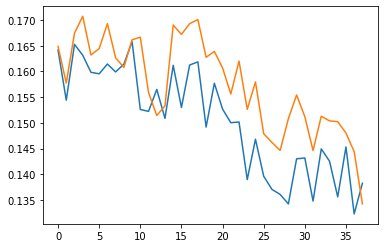

In [61]:
train_loss_history = [train_loss_history[i].data for i in range(len(train_loss_history))]
test_loss_history = [test_loss_history[i].data for i in range(len(test_loss_history))]

plt.plot(train_loss_history)
plt.plot(test_loss_history)

# 4.4 Семинар: Классификация рукописных чисел полносвязанной сетью

Как было сказано в предыдущем уроке, полносвязный слой может быть представлен как матричное умножение матрицы входов (X) и матрицы весов нейронов слоя (W), плюс вектор bias'ов слоя (b). 

В документации к классу torch.nn.Linear (полносвязному слою) написано следующее: 

Applies a linear transformation to the incoming data: 
$$y = xA^T + b$$

$А$ здесь – это то, как PyTorch хранит веса слоя. Но чтобы эта матрица совпала с $W$ из предыдущего урока, нужно её сперва транспонировать.

**Давайте реализуем функциональность torch.nn.Linear и сверим с оригиналом!**

Пусть у нас будет 1 объект $x$ на входе с двумя компонентами. Его мы передадим в полносвязный слой с 3-мя нейронами и получим, соотсветственно, 3 выхода. После напишем эту же функциональность с помощью матричного умножения. 

**Sample Input:** anything

**Sample Output:** tensor([[1, 1, 1]], dtype=torch.uint8)

In [ ]:
import torch

In [62]:
# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])
x

tensor([[10., 20.]])

In [67]:
# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)
fc

Linear(in_features=2, out_features=3, bias=True)

In [68]:
# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами
fc.weight.data

tensor([[-0.4409, -0.3148],
        [ 0.2591,  0.6928],
        [ 0.4328, -0.0470]])

In [70]:
# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w
fc.weight.data

tensor([[11., 12.],
        [21., 22.],
        [31., 32.]])

In [71]:
fc.bias.data

tensor([ 0.3578,  0.6551, -0.2264])

In [72]:
b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b
fc.bias.data

tensor([[31., 32., 33.]])

In [73]:
# Получим выход fc-слоя:
fc_out = fc(x)
fc_out

tensor([[381., 682., 983.]], grad_fn=<AddmmBackward0>)

In [74]:
w

tensor([[11., 12.],
        [21., 22.],
        [31., 32.]])

In [81]:
x.shape, w.T.shape

(torch.Size([1, 2]), torch.Size([2, 3]))

In [86]:
torch.matmul(x, w.t())

tensor([[350., 650., 950.]])

In [84]:
b

tensor([[31., 32., 33.]])

In [83]:
# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
fc_out_alternative = torch.matmul(x, w.T) + b
fc_out_alternative

tensor([[381., 682., 983.]])

In [85]:
# Проверка осуществляется автоматически вызовом функции
print(fc_out == fc_out_alternative)
# (раскомментируйте, если решаете задачу локально)

tensor([[True, True, True]])


В предыдущем шаге мы написали функцию, эмулирующую fc-слой. Проверим, что по ней правильно считается градиент. 

Функцию backward() в PyTorch можно посчитать только от скалярной функции (выход из такой функции – одно число). Это логично, так как loss-функция выдает всегда одно число. Но fc-слой, который мы проэмулировали, имел 3 выхода. Предлагаем их просуммировать, чтобы получить в итоге скалярную функцию. Заметим, впрочем, что можно было бы выбрать любую агрегирующую операцию, например умножение.

Дополните код так, чтобы градиент по весам и смещениям (bias) совпадал с аналогичным градиентом в вашей фунции.

Чем обусловлен полученный градиент? Изменится ли он, если мы подадим другие входы или другую инициализацию весов?

Sample Input: anything


Sample Output:

In [ ]:
'''
fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
'''

In [93]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты 
# (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = (torch.matmul(x, w.t()) + b).sum() # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)
# (раскомментируйте, если работаете над задачей локально)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])


In [88]:
torch.matmul(x, w.T) + b

tensor([[381., 682., 983.]])

In [90]:
(torch.matmul(x, w.T) + b).sum()

tensor(2046.)